# A/B Testing Pricing

Company XYZ sells a software for \$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (\$39), while a random sample of 33% users a higher price (\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially, you were asked the following questions:
- Should the company sell its software for \$39 or \$59?
- The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
- [Bonus] The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

# Data Description

The two tables are:

## test_results - data about the test

Columns:
- user_id: the Id of the user. Can be joined to user_id in user_table
- timestamp: the date and time when the user hit for the first time company XYZ webpage. It is in user local time
- source: marketing channel that led to the user coming to the site. It can be:
 - ads: [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google ads, yahoo ads, etc.
 - seo: [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google search, yahoo, facebook, etc.
 - friend_referral: user coming from a referral link of another user
 - direct_traffic: user coming by directly typing the address of the site on the browser
- device: user device. Can be mobile or web.
- operative_system: user operative system. Can be: “windows”, “linux”, “mac” for web, and “android”, “iOS” for mobile. "Other" if it is none of the above
- test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower price)
- price: the price the user sees. It should match test
- converted: whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

## user_table - Information about the user

Columns:
- user_id: the Id of the user. Can be joined to user_id in test_results table
- city: the city where the user is located. Comes from the user ip address
- country: in which country the city is located
- lat: city latitude - should match user city
- long: city longitude - should match user city

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from scipy.stats import ttest_ind

# Index
1. [Exploration of Test Results](#explore_test)
    1. [Evaluating Test Results](#test_results)
2. [Exploration of User Behavior](#explore_users)
    1. [Evaluating User Behavior](#user_results)
3. [Shorter Testing Time](#shorter_test)

<a name='explore_test'></a>
# Initial Exploration of Test Results

In [2]:
test_results = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked---Private/main/CSVs/pricing_test_results.csv?token=ALJ4RGZSZU2VON7BNOV75VLACCHFY')
print(test_results.shape)
test_results.head()

(316800, 8)


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


Some of the timestamp have the value `60` in the minutes and seconds positions. To correct it we'll just zero out the minutes and seconds values for those timestamps. Ideally, the cause of the error would be found and corrected while also informing how to properly correct the timestamps.

In [3]:
def correct_timestamps(timestamp):
    if ':60' in timestamp:
        return timestamp[:-5]+'00:00'
    else:
        return timestamp

test_results['timestamp'] = test_results['timestamp'].apply(correct_timestamps)
test_results['timestamp'] = pd.to_datetime(test_results['timestamp'])

In [4]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           316800 non-null  int64         
 1   timestamp         316800 non-null  datetime64[ns]
 2   source            316800 non-null  object        
 3   device            316800 non-null  object        
 4   operative_system  316800 non-null  object        
 5   test              316800 non-null  int64         
 6   price             316800 non-null  int64         
 7   converted         316800 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 19.3+ MB


In [5]:
test_results.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,user_id,timestamp,source,device,operative_system,test,price,converted
count,316800.000000,316800,316800,316800,316800,316800.000000,316800.000000,316800.000000
unique,NaN,137922,12,2,6,NaN,NaN,NaN
top,NaN,2015-04-24 11:00:00,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,NaN,45,60357,186471,100976,NaN,NaN,NaN
first,NaN,2015-03-02 00:04:12,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-05-31 23:59:45,NaN,NaN,NaN,NaN,NaN,NaN
mean,499281.341840,NaN,NaN,NaN,NaN,0.360079,46.205051,0.018333
std,288591.154044,NaN,NaN,NaN,NaN,0.480024,9.601487,0.134154
min,3.000000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
25%,249525.750000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000


In [6]:
test_results['source'].value_counts(normalize=True)

direct_traffic     0.190521
ads-google         0.187434
ads_facebook       0.168548
ads_other          0.094306
seo-google         0.073153
ads-bing           0.072200
seo_facebook       0.066935
friend_referral    0.065325
seo-other          0.029230
ads-yahoo          0.023936
seo-yahoo          0.021616
seo-bing           0.006796
Name: source, dtype: float64

In [7]:
test_results['device'].value_counts(normalize=True)

mobile    0.588608
web       0.411392
Name: device, dtype: float64

Before we evaluate the test we need to confirm the test is randomly distributed. Looking at the distributions, we see a couple of issues.

First the test price point is not homogenous; both the test and control groups contain both price points. We can fix that by dropping those values for our evaluation.

The other issue is that OS and possibly device are not evenly split either. We'll confirm this with a chi-squared test below.

test                    0         1
source                             
ads-bing         0.638701  0.361299
ads-google       0.637667  0.362333
ads-yahoo        0.635369  0.364631
ads_facebook     0.638606  0.361394
ads_other        0.645468  0.354532
direct_traffic   0.642162  0.357838
friend_referral  0.634694  0.365306
seo-bing         0.619601  0.380399
seo-google       0.651650  0.348350
seo-other        0.635961  0.364039
seo-yahoo        0.637120  0.362880
seo_facebook     0.635275  0.364725


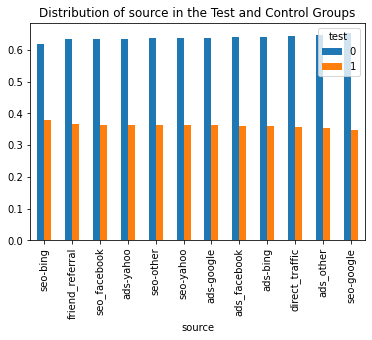

test           0         1
device                    
mobile  0.646111  0.353889
web     0.631064  0.368936


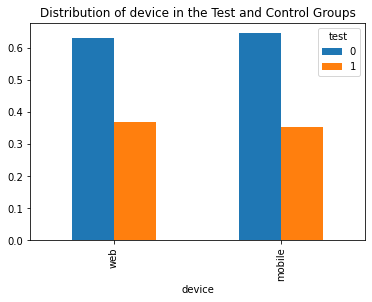

test                     0         1
operative_system                    
android           0.643358  0.356642
iOS               0.647934  0.352066
linux             0.533736  0.466264
mac               0.652422  0.347578
other             0.647865  0.352135
windows           0.629764  0.370236


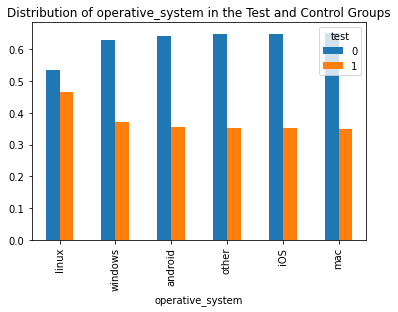

test          0         1
price                    
39     0.999235  0.000765
59     0.001840  0.998160


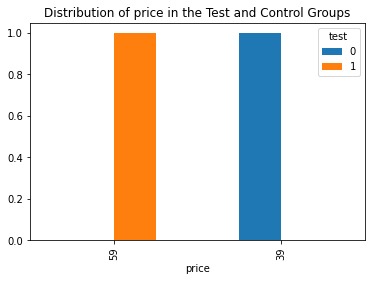

In [8]:
for col in ['source', 'device', 'operative_system', 'price']:
    temp = pd.crosstab(test_results[col], test_results['test'],
                       normalize='index')
    print(temp)
    temp.sort_values([0,1]).plot.bar()
    plt.title('Distribution of ' + col +' in the Test and Control Groups')
    plt.show()

Through the chi-squared test we've confirmed that `operative_system` and `device` are not split randomly.

In [9]:
chi_df = test_results.drop('timestamp', axis='columns').copy()
cols = ['source', 'device', 'operative_system']

for col in cols:
    chi_df[col] = LabelEncoder().fit_transform(test_results[col])

chi_values, p_values = chi2(chi_df.loc[:, cols], chi_df["test"])
pd.DataFrame({'chi2_value':chi_values, 'p_value':p_values}, 
             index=cols).sort_values(by='p_value')

,chi2_value,p_value
operative_system,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


Correct the test and control observations with the wrong price points.

In [10]:
test_results = test_results[((test_results['test']==0)
                           & (test_results['price']==39))
                           | ((test_results['test']==1)
                           & (test_results['price']==59))]
                           
test_results.groupby('test')['price'].value_counts(normalize=True)

test  price
0     39       1.0
1     59       1.0
Name: price, dtype: float64

<a name='test_results'></a>
## Evaluating Test Results

Before running the test we can see that the test group has a higher average revenue even though it has a lower conversion rate than the control group.

In [11]:
test_results['revenue'] = test_results['price'] * test_results['converted']
test_results.groupby('test')['converted', 'revenue'].agg(
        {'converted':['count', 'mean'], 'revenue': ['mean', 'sum']})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


converted             revenue        
         count      mean      mean     sum
test                                      
0       202517  0.019900  0.776083  157170
1       113918  0.015555  0.917748  104548

In [12]:
t_stat, p_value = ttest_ind(test_results[test_results['test'] == 0]['revenue'],
                            test_results[test_results['test'] == 1]['revenue'],
                            equal_var=False)

pd.DataFrame({'p-value': [p_value], 't-stat': [t_stat]})

,p-value,t-stat
0,1.097258e-08,-5.715225


Based on this t-test alone, we can reject the null hypothesis, however there are issues with the test that must be addressed. We must rerun the test after finding out why `operative_system` and `device` are not randomly split between the test and control groups. We must also find out why a handful of observations had the wrong price point for the test and control groups. Once these issues are corrected we can attempt the test again to see if the higher price point holds.

<a name='explore_users'></a>
# Exploration of User Behavior

In [13]:
users = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked---Private/main/CSVs/pricing_user_table.csv?token=ALJ4RGZXDHJUAEZZCI2UGM3ACCHF2')
print(users.shape)
users.head()

(275616, 5)


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [14]:
df = pd.merge(test_results, users, how='left')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,revenue,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0,Fishers,USA,39.95,-86.02


In [15]:
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

The looking at the user info is a lot of repetition so we'll minimize the amount of repeated code and dump it all in a for loop.


 hour


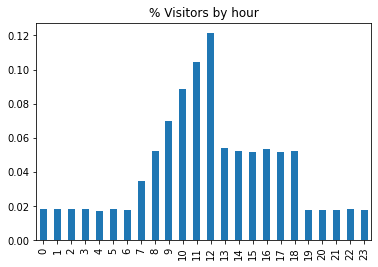

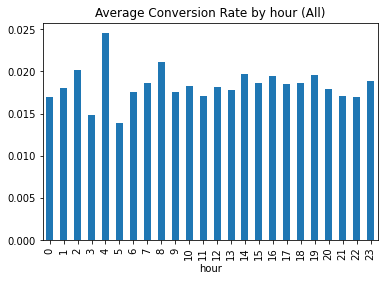

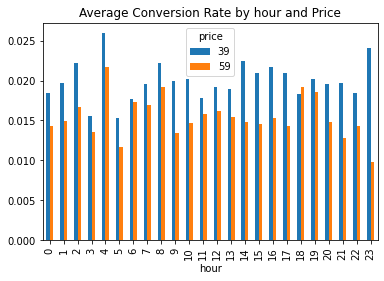

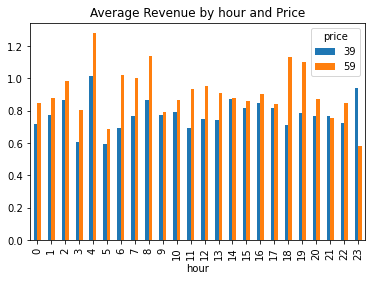


 source


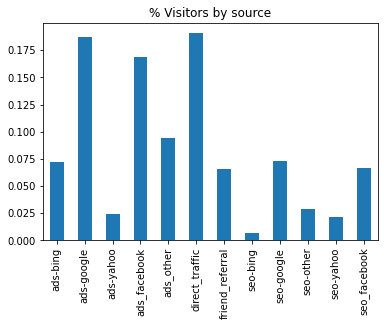

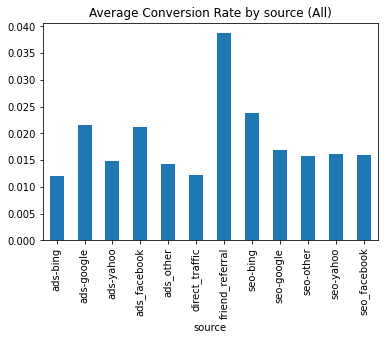

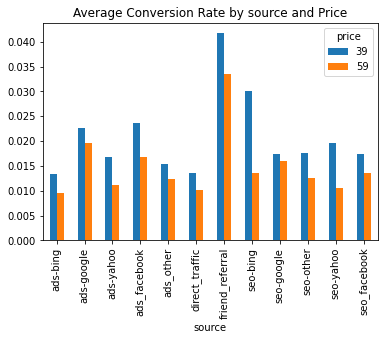

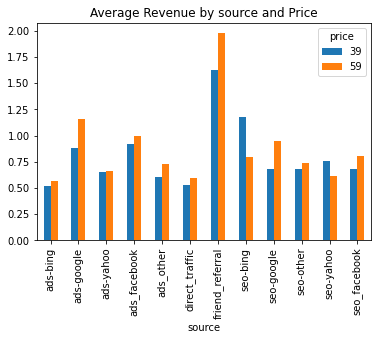


 operative_system


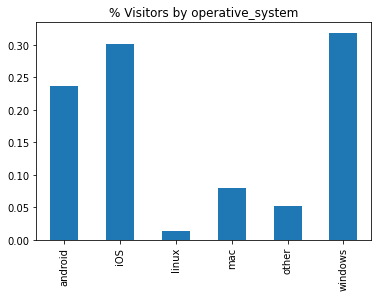

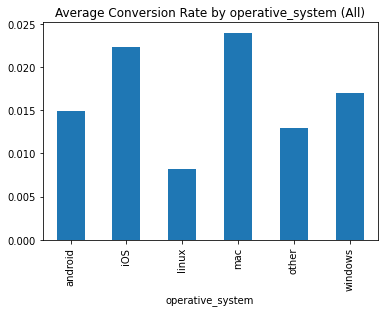

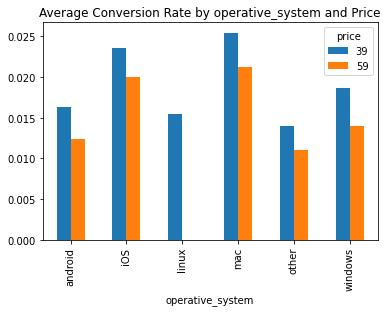

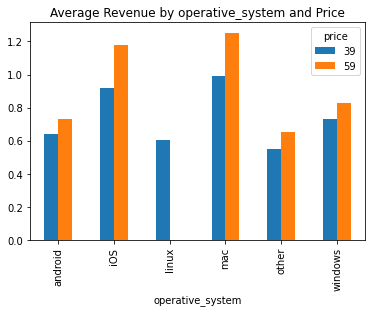


 device


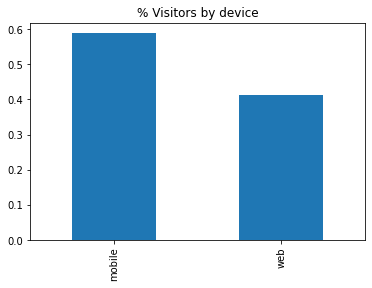

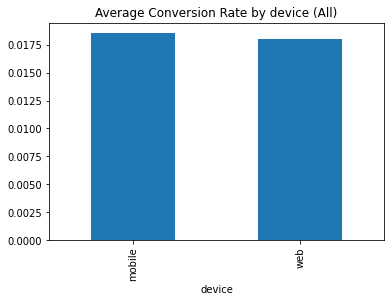

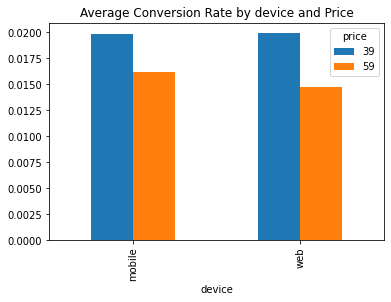

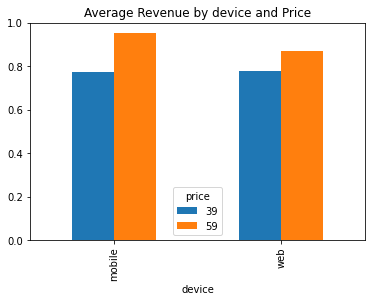

In [51]:
for col in ['hour', 'source', 'operative_system', 'device']:
    print('\n', col)
    df[col].value_counts(normalize=True).sort_index().plot.bar()
    plt.title('% Visitors by ' + col)
    plt.show()
    df.groupby(col)['converted'].mean().plot.bar();
    plt.title('Average Conversion Rate by ' + col + ' (All)')
    plt.show()
    df.pivot_table('converted', col, 'price').plot.bar();
    plt.title('Average Conversion Rate by ' + col + ' and Price')
    plt.show()
    df.pivot_table('revenue', col, 'price').plot.bar()
    plt.title('Average Revenue by ' + col + ' and Price')
    plt.show()

Slight variation with `dayofweek` because I want to have the written day and not the numerical designation. Due to this `dayofweek` is separate but still the same sets of graphs as above.

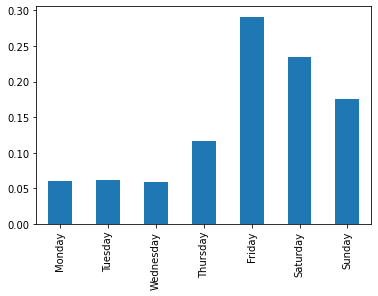

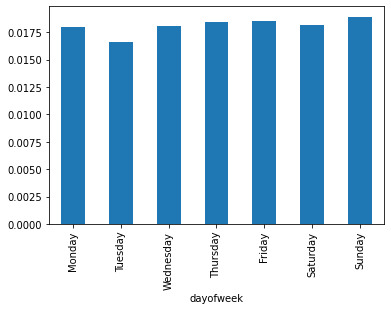

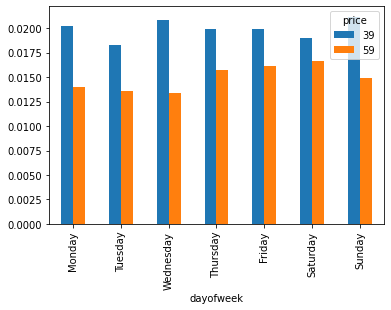

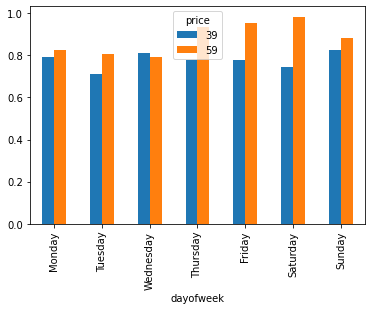

In [17]:
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['dayofweek'].value_counts(normalize=True).sort_index().rename(
                                                       days_of_week).plot.bar();
plt.show()
df.groupby('dayofweek')['converted'].mean().rename(days_of_week).plot.bar();
plt.show()
df.pivot_table('converted', 'dayofweek', 'price').rename(days_of_week).plot.bar();
plt.show()
df.pivot_table('revenue', 'dayofweek', 'price').rename(days_of_week).plot.bar();
plt.show()

Not expecting too much from city but we don't want to leave it out. Interestingly, North Atlanta loves the software.

In [37]:
pd.pivot_table(df, 'converted', 'city', 'price',
               margins='index').sort_values(by='All', ascending=False)[:10]

price,39,59,All
city,,,
North Atlanta,0.000000,0.250000,0.200000
Catonsville,0.250000,0.000000,0.153846
Saint Charles,0.200000,0.000000,0.142857
Parkway-South Sacramento,0.181818,0.000000,0.117647
Findlay,0.000000,0.166667,0.111111
Blue Springs,0.066667,0.166667,0.095238
Bonita Springs,0.250000,0.000000,0.090909
Lehigh Acres,0.000000,0.210526,0.086957
Parsippany-Troy Hills Township,0.074074,0.100000,0.081081


In [36]:
pd.pivot_table(df, 'revenue', 'city', 'price',
               margins='index').sort_values(by='All', ascending=False)[:10]

price,39,59,All
city,,,
North Atlanta,0.000000,14.750000,11.800000
Findlay,0.000000,9.833333,6.555556
Catonsville,9.750000,0.000000,6.000000
Saint Charles,7.800000,0.000000,5.571429
Lehigh Acres,0.000000,12.421053,5.130435
Blue Springs,2.600000,9.833333,4.666667
Parkway-South Sacramento,7.090909,0.000000,4.588235
Parsippany-Troy Hills Township,2.888889,5.900000,3.702703
Bonita Springs,9.750000,0.000000,3.545455


<a name='user_results'></a>
## Evaluating User Behavior

Looking at the user behavior we find a couple of properties that increase conversion rate:
- `source`:`friend_referral`
- `operative_system`:`mac` and `iOS`
- `price`:`39`
- `timestamp`: `hour`
We also see our user traffic is impacted by `dayofweek` and `hour`.

From what we found we can make a few suggestions to improve conversion rate/revenue.
- Highlight  friend referrals in some way, such as with a perk for inviting a friend, or altering the UI/UX to draw attention to friend referrals.
- Increase support of Mac/iOS to foster the community and start an advertising campaign to target those users.
- Offer some sort of promotion at peak traffic times, such as a Friday at Noon flash sale.
- Test and offer tiered pricing and the ability to upgrade. Pricing is a major factor on the conversion rate so having price points that appeals to the various segments you are better able to capture each segment.
- Linux users have a low conversion rate. The development team should check for issues surrounding the OS and maybe provide written support for using the software on Linux.
- Finally, we see conversion rate varies by city but that even at the higher price point of $59 `North Atlanta` has a conversion rate of 25%. With Atlanta being a major city, spending time to foster a community for the software users in that city may be worthwhile and would pair well with the friend referral suggestion.

<a name='shorter_test'></a>
# Shorter A/B Test

The VP of Product is correct that they could have done a shorter test and still achieved a statistically significant result. The test that was completed ran for 90 days however you could reduce that down to 14 days. I would not recommend going below 2 weeks to ensure you capture possible weekly trends. The test sample size could also be reduced dramatically depending on the minimum effect you are looking to detect. The needed sample size can be calculated or you can use the [tool here](https://www.evanmiller.org/ab-testing/sample-size.html#!1.9;95;1;1;0) to verify.

Assuming a minimum detectable effect of 1% we would need a sample size of at least 7,279 (vs. 113918 used). Spreading that out over the 14 days would require just 520 users each day out of the average 3,515 users/day (14.8% of daily users). By using a smaller sample size we can reduce the impact of a possible failed experiment and it allows us to run additional A/B tests concurrently.